# Vulcain Nozzle Extension

This is an extension of the 'Vulcain Combustion Chamber.ipynb' notebook, but here we will attempt to model the dump-cooled nozzle extension here. <b> The key thing to note is that the nozzle extension using <u>spiralling</u> channels</b>


### References:

- [1] - Kirner et al 1993, Development Status of the Vulcain Thrust Chamber (http://ftp.demec.ufpr.br/CFD/bibliografia/propulsao/kirner_et_al_1993.pdf)
- [2] - Nydén et al 1991, Development of the HM60-Vulcain nozzle extension (https://arc.aiaa.org/doi/10.2514/6.1991-2566)
- [3] - LeBail et al 1993, Numerical analysis of high aspect ratio cooling passage flow and heat transfer (https://arc.aiaa.org/doi/pdf/10.2514/6.1993-1829)
- [4] - High Temp Metals, Inconel 600 Technical Data, (https://www.hightempmetals.com/techdata/hitempInconel600data.php)

In [36]:
import bamboo as bam
import pypropep as ppp
from CoolProp.CoolProp import PropsSI
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

### Collect Vulcain data

Using a an online graph image-to-data converter (http://www.graphreader.com/), we can obtain the raw data.

In [37]:
# Coolant temperature in K [1]
coolant_temperature_data = np.loadtxt("data/Kirner_1993_Fig15_Temp.csv", delimiter =',', skiprows = 1)
coolant_temperature_data = {"x" : coolant_temperature_data[:,0],
                            "y" : coolant_temperature_data[:,1]}

# Engine contour (m) - up to the beginning of the nozzle extension [1]
chamber_geometry = np.loadtxt("data/Kirner_1993_Fig14_Contour.csv", delimiter =',', skiprows = 1)
chamber_geometry = {"x" : chamber_geometry[:,0],
                    "y" : chamber_geometry[:,1]}

extension_geometry = np.loadtxt("data/Kirner_1993_Fig15_Contour.csv", delimiter =',', skiprows = 1)
extension_geometry = {"x" : extension_geometry[:,0],
                      "y" : extension_geometry[:,1]}


# Shift the extension geometry data, then combine with the chamber data
extension_geometry["x"] = extension_geometry["x"] + chamber_geometry["x"][-1]
coolant_temperature_data["x"] = coolant_temperature_data["x"] + chamber_geometry["x"][-1]

engine_contour = {}
engine_contour["x"] = list(chamber_geometry["x"]) + list(extension_geometry["x"])
engine_contour["y"] = list(chamber_geometry["y"]) + list(extension_geometry["y"])

# Cooling channel
coolant_inlet_p0 = 137.9e5          # Coolant inlet pressure [3] (guess that p0 ~= p)
mdot_coolant = 1.75                 # Coolant mass flow rate [2] 
k_wall = 19.2                       # Wall thermal conductivity [4] for Inconel 600 [1]
wall_thickness = 0.4e-3             # Wall thickness between coolant and exhaust gas [2]
number_of_channels = 456            # Number of channels [2]
channel_height = 3.2e-3             # Height of cooling channels [2]
blockage_ratio = 0.2                # Fraction of cooling channel flow area that is blocked by fins/walls [2]
pitch = 2.07                        # Cooling channel helix pitch [2] - estimated from Figure 1

# Experimental data
experimental_T_in = 48.035      # Experimental coolant inlet temperature, K [1]
experimental_T_out = 871.907    # Experimental coolant outlet temperature, K [1]

### Get chamber conditions

Use pypropep. The Vulcain uses a liquid oxygen and liquid hydrogen fed system.

In [38]:
thrust = 1007.7e3   # Vacuum thrust, N [1]
isp = 439*9.81      # Specific impulse, m/s [1]
pc = 100e5          # Chamber pressure, bar [1]
OF_ratio = 5.6      # O/F ratio (seems to be by mass) [1]

expected_mdot = thrust / isp

# Use pypropep to get chamber temperature
ppp.init()
p_froz = ppp.FrozenPerformance()
lox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
lh2 = ppp.PROPELLANTS['HYDROGEN (CRYOGENIC)']

# Add propellants by mass fractions
p_froz.add_propellants_by_mass([(lox, OF_ratio), (lh2, 1)])

# Adiabatic combustion using chamber pressure                      
p_froz.set_state(P = pc/1e5, Pe = 1)   

# Get results - use throat conditions for gamma and cp! Otherwise the perfect gas model deviates a lot from equilibrium calculations.
gamma = p_froz.properties[1].Isex   # pyrpopep uses 'Isex' for the ratio of specific heats. Index 1 means throat conditions
cp = 1000*p_froz.properties[1].Cp   # Cp is given in kJ/kg/K, we want J/kg/K
Tc = p_froz.properties[0].T         # Index 0 means chamber conditions

print(f"Chamber temperature = {Tc} K")

print("\nCombustion product composition:")
print(p_froz.composition["throat"])

Loaded 1921 thermo species
Loaded 1031 propellants
Chamber temperature = 3459.2606127242298 K

Combustion product composition:
[('H2O', 0.6493671319106238), ('H2', 0.2896925690851782), ('OH', 0.028980423622929952), ('H', 0.028801796474919292), ('O', 0.0016810512414820072), ('O2', 0.0014520541971763574), ('HO2', 1.7031381331243065e-05), ('H2O2', 7.94208687267654e-06), ('O3', 0.0)]


### Bamboo engine model

First set up the perfect gas model, the geometry, and combustion chamber conditions. Use this to get the mass flow rate of exhaust gas.

In [39]:
# Set up the chamber conditions and geometry
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)   
chamber_conditions = bam.ChamberConditions(p0 = pc, T0 = Tc)
geometry = bam.Geometry(xs = engine_contour["x"], ys = engine_contour["y"])

# Set up an engine quickly just to get our perfect gas mass flow rate (used later)
engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry)

Now use Cantera to get the exhaust gas transport properties, and CoolProp to get the coolant transport properties.

In [40]:
# Setup the exhaust gas transport properties using Cantera
gas = ct.Solution('gri30.yaml')
gas.TPY = Tc, pc, f"H2:{1}, O2:{OF_ratio}"
gas.equilibrate("TP")

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number

exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

# Set up the coolant transport properties using CoolProp
# Round temperatures up to 12 K - CoolProp seems unhappy below this for LH2
def Pr_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")

def mu_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")

def k_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")

def cp_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN") 

def rho_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 

# Note that H2 doesn't seem to exactly 'boil-off' in the state it's in - it's supercritical
coolant_transport = bam.TransportProperties(Pr = Pr_coolant,
                                            mu = mu_coolant,
                                            k = k_coolant,
                                            cp = cp_coolant,
                                            rho = rho_coolant)

Put the final pieces together, set up the `Engine` object, and plot the geometry.

In [41]:
cooling_jacket = bam.CoolingJacket(T_coolant_in = coolant_temperature_data["y"][0],                           
                                   p0_coolant_in = coolant_inlet_p0, 
                                   coolant_transport = coolant_transport, 
                                   mdot_coolant = mdot_coolant, 
                                   configuration = "spiral", 
                                   channel_height = channel_height,
                                   number_of_fins = number_of_channels,
                                   blockage_ratio = blockage_ratio,
                                   pitch = pitch,
                                   xs = [extension_geometry["x"][0], extension_geometry["x"][-1]])

wall = bam.Wall(material = bam.Material(k = k_wall), thickness = wall_thickness)

engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    cooling_jacket = cooling_jacket,
                    exhaust_transport = exhaust_transport,
                    walls = wall,
                    exhaust_convection = "bartz-sigma")

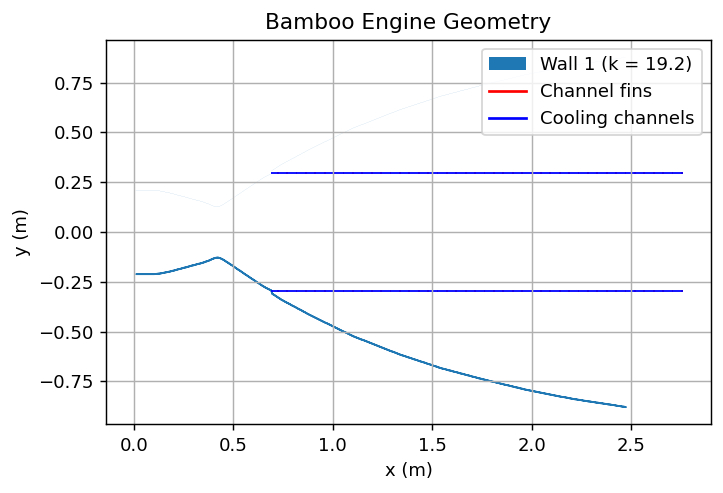

In [42]:
engine.plot()
plt.title("Bamboo Engine Geometry")
plt.show()

In [43]:
# Run simulation
bamboo_data = engine.steady_heating_analysis(counterflow = False)

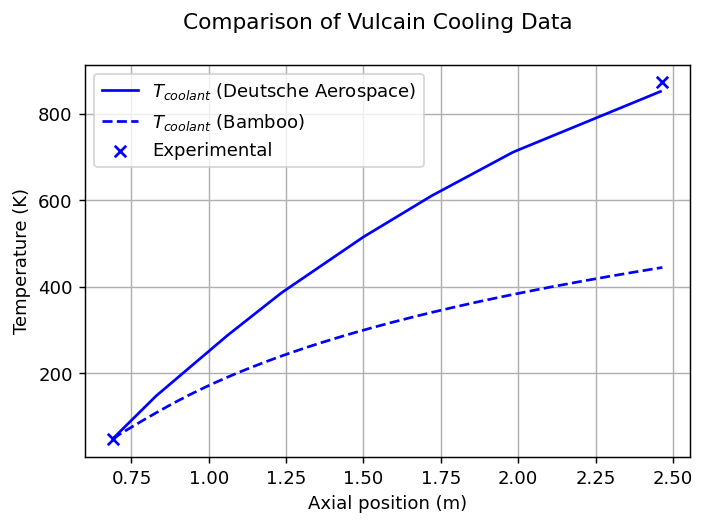

Experimental coolant exit temperature (Deutsche Aerospace) = 871.91 K
Predicted coolant exit temperature (Bamboo) = 444.66 K
Percentage error in coolant exit temperature = 49.00%



In [44]:
# Compare results with data from paper
fig, ax = plt.subplots()
fig.suptitle("Comparison of Vulcain Cooling Data")

# Plot coolant temperatures      
ax.plot(coolant_temperature_data["x"], 
         coolant_temperature_data["y"], 
         label = r"$T_{coolant}$ (Deutsche Aerospace)", 
         color= "blue")

ax.plot(bamboo_data["x"], bamboo_data["T_coolant"], 
         label= r"$T_{coolant}$ (Bamboo)", 
         color= "blue", 
         linestyle = "--")

# Plot their experimental datapoints
ax.scatter(bamboo_data["x"][0], experimental_T_in, s = 40, marker = 'x', color = "blue")
ax.scatter(bamboo_data["x"][-1], experimental_T_out, s = 40, marker = 'x', color = "blue", label = "Experimental")

# Formatting
ax.set_ylabel("Temperature (K)")
ax.set_xlabel("Axial position (m)")
ax.grid()
ax.legend()
plt.show()

print(f'Experimental coolant exit temperature (Deutsche Aerospace) = {experimental_T_out:.2f} K')
print(f'Predicted coolant exit temperature (Bamboo) = {bamboo_data["T_coolant"][-1]:.2f} K')
percent_error = 100*(bamboo_data["T_coolant"][-1] - experimental_T_out)/experimental_T_out
print(f'Percentage error in coolant exit temperature = {abs(percent_error):.2f}%\n')

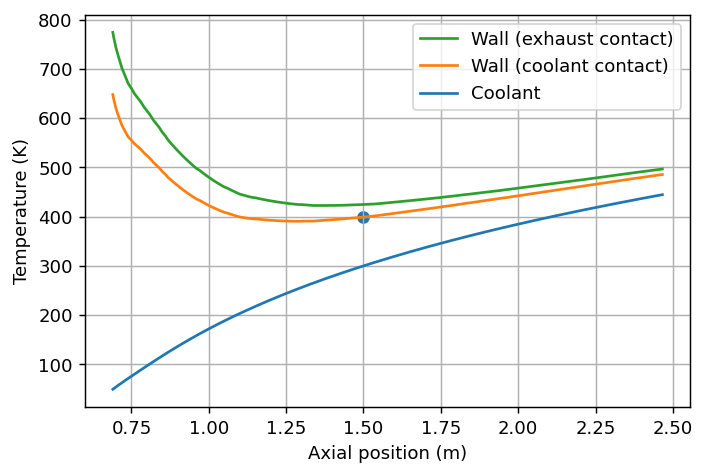

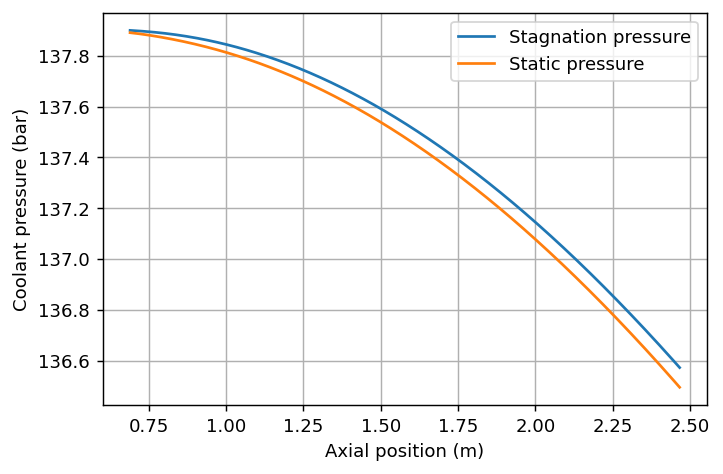

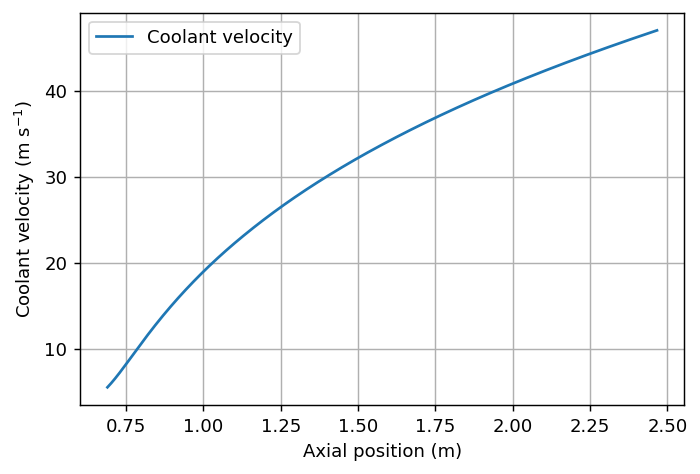

In [49]:
bam.plot.plot_temperatures(bamboo_data, only_indexes = [0,1,2])
plt.scatter(1.5, 400, label = "test ???")
plt.show()

bam.plot.plot_jacket_pressure(bamboo_data)
bam.plot.plot_coolant_velocity(bamboo_data)

In [46]:
print(bamboo_data["rho_coolant"][0])
print(bamboo_data["V_coolant"][0])

60.13463255788327
5.491652854986242


In [47]:
print(bamboo_data["rho_coolant"][-1])
print(bamboo_data["V_coolant"][-1])

7.023217196226656
47.02097590652253
